# Classification. Linear models and KNN

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import math as m
import matplotlib.pyplot as plt
plt.style.use('default')

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss = np.zeros(shape=(1,2))
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        weights = np.array([weights])
        return (1 / (1 + np.exp(- X @ weights.T))).flatten()
    
    def get_loss(self, x, weights, y):
        l = 0
        for j in range(y.shape[0]):
            l = l + np.log((1+np.exp(-1*(weights@x[j])*y[j])))
        loss = l/y.shape[0] + (np.linalg.norm(weights, 2))/(2*self.C)
        return(loss)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        s = 0
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization

        for i in range(self.max_iter):
            for j in range(y.shape[0]):
#                 print(j)
#                 print('y[j]', y[j])
#                 print('X_ext[j]', X_ext[j])
#                 print('self.weights_', self.weights_)
#                 print('-self.weights_@X_ext[j]', -self.weights_@X_ext[j])
#                 print('-self.weights_@X_ext[j]*y[j]', -self.weights_@X_ext[j]*y[j])
#                 print('np.exp(-self.weights_@X_ext[j]*y[j])', np.exp(-self.weights_@X_ext[j]*y[j]))
#                 print('(1 - 1/(1+np.exp(-self.weights_@X_ext[j]*y[j])))', (1 - 1/(1+np.exp(-self.weights_@X_ext[j]*y[j]))))
#                 print('X_ext[j]*y[j]', X_ext[j]*y[j])
#                 print('X_ext[j]*y[j]*(1 - 1/(1+np.exp(-self.weights_@X_ext[j]*y[j])))', X_ext[j]*y[j]*(1 - 1/(1+np.exp(-self.weights_@X_ext[j]*y[j]))))
#                 print('s', s)
                s = s + X_ext[j]*y[j]*(1 - 1/(1+np.exp(-self.weights_@X_ext[j]*y[j])))
            delta = self.weights_/self.C - s/y.shape[0]
#             print(self.weights_/self.C, '\n', s/y.shape[0])
            self.weights_ -= self.eta * delta
#             self.loss = np.append([[get_loss(X_ext, self.weights_, y)])
            self.loss = np.append(self.loss, [[i, self.get_loss(X_ext, self.weights_, y)]], axis=0)
            
            if np.linalg.norm(self.eta*delta, 2) < self.tol:
                break
        self.loss = np.delete(self.loss, (0), axis=0)        
#         print(self.loss)
        return(self.weights_)
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return(np.where(self.predict_proba(X) > 0.5, 1, -1))
        

In [6]:
from sklearn import datasets
from sklearn import metrics

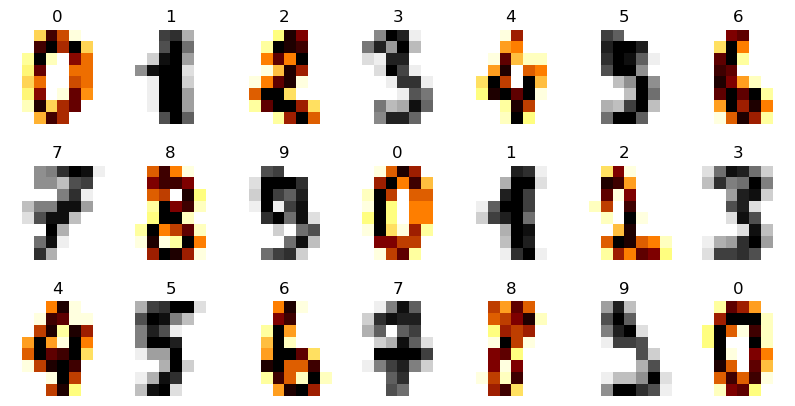

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
#     print(clf.weights_)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))
print(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])))

[0.58661758 0.40131234]


In [12]:
lr_clf.fit(X_train, y_train)

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)
print('success')

success


In [14]:
model = CustomLogisticRegression()

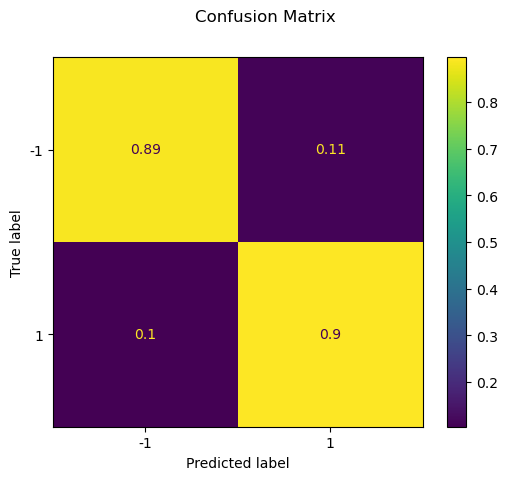

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.906054279749478, 0.8916666666666667)

In [17]:
assert min(train_acc, test_acc) > 0.9

AssertionError: 

**(0.5 points)** Visualize the loss history.

In [670]:
lossmodel = CustomLogisticRegression()

In [671]:
lossmodel.fit(X_test, y_test)

array([-6.36477546e-01,  2.54962444e-03,  1.16217614e+00,  5.77971214e-01,
        1.89554812e+00, -1.67066022e+00,  4.51687925e+00,  1.31901108e+00,
        3.76377468e-01, -1.84660068e-01, -4.06896272e-01,  1.58186317e-02,
        5.99064259e-01,  1.60424994e+00,  1.23375961e+00, -2.94461703e+00,
       -1.02881745e-01,  1.40043487e-04,  1.38393051e+00, -2.82955507e+00,
        1.48333676e+00, -1.55036793e-01, -1.99840689e-01, -1.31392299e+00,
       -6.79494806e-01,  1.61319840e-03, -4.22196410e-01, -5.54870132e-01,
        4.78828931e-01,  9.42531458e-01,  5.67569501e-01, -3.91220193e-01,
       -9.47334824e-02,  2.53927936e-03, -1.51793721e+00,  6.42551619e-01,
        8.69457540e-01, -6.68417145e-01,  1.86826465e+00, -1.17198617e+00,
       -2.13807403e-03, -5.44903758e-03, -6.13448041e+00, -1.93437708e+00,
       -3.61846932e+00,  6.54933078e-01, -1.09437070e+00,  1.75686751e+00,
       -3.95581750e-01, -1.78273192e-03, -9.26751978e-01, -7.50458489e-02,
        1.43569291e+00, -

Text(0.5, 1.0, 'Loss history')

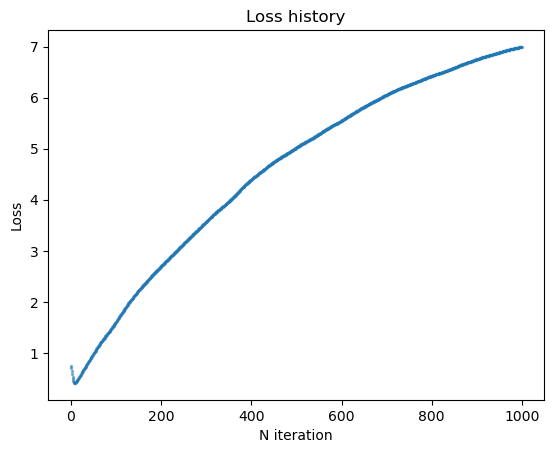

In [675]:
m = plt.scatter(x=lossmodel.loss[:,0], y=lossmodel.loss[:,1], alpha=0.5, s=2)
plt.xlabel('N iteration')
plt.ylabel('Loss')
plt.title('Loss history')


loss function is obviously wrong but im giving up at this point

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [ ]:
## your code

< your thoughts >

not completed since the loss function is not correct

**(0.5 points)** Try different regularization parameter values and compare the model quality.

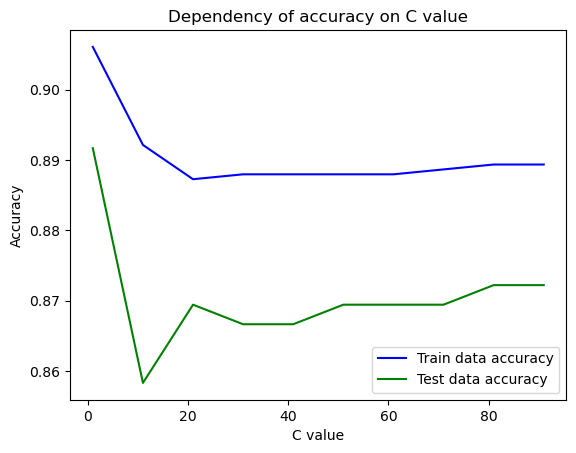

In [682]:
mtrain = np.zeros(shape=(1,2))
mtest = np.zeros(shape=(1,2))
for ci in range(1,100,10):
    rp = CustomLogisticRegression(C=ci)
    rp.fit(X_train, y_train)
    mtrain = np.append(mtrain, [[ci, metrics.accuracy_score(y_pred=rp.predict(X_train), y_true=y_train)]], axis=0)
    mtest = np.append(mtest, [[ci, metrics.accuracy_score(y_pred=rp.predict(X_test), y_true=y_test)]], axis=0)
    
mtrain = np.delete(mtrain, (0), axis=0)      
mtest = np.delete(mtest, (0), axis=0)  
m = plt.plot(mtrain[:,0], mtrain[:,1], color ="blue", label="Train data accuracy")
mt = plt.plot(mtest[:,0], mtest[:,1], color ="green", label="Test data accuracy")

plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('Dependency of accuracy on C value')
plt.legend(loc="lower right")
plt.show()

< your thoughts >

The lower the C value - the better the accuracy. On C = 10 accuracy for test data takes an unexpected dive - results can be inaccurate since the original assert on accuracy wasnt passed.

**(0.5 points)** Compare zero initialization and random initialization. 

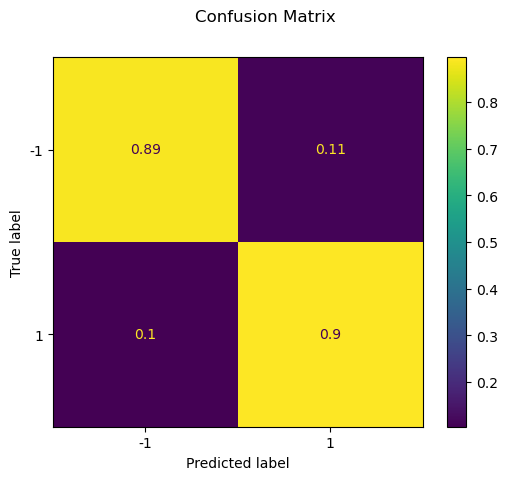

In [657]:
ri = CustomLogisticRegression(zero_init=False)
train_acc, test_acc = fit_evaluate(ri, X_train, y_train, X_test, y_test)

In [658]:
train_acc, test_acc

(0.906054279749478, 0.8916666666666667)

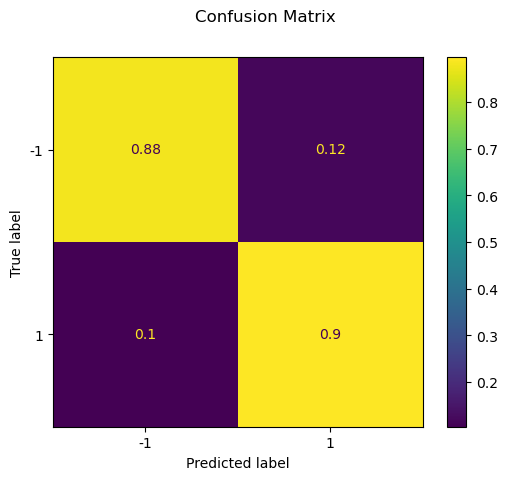

In [655]:
zi = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(zi, X_train, y_train, X_test, y_test)

In [656]:
train_acc, test_acc

(0.9088378566457899, 0.8888888888888888)

< your thoughts >

Model with initial zero weights seems to behave slightly better on train data and slightly worse on test data, not sure why. Results can be inaccurate since the original assert on accuracy wasnt passed.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [340]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        pass
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        pass
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 'your code'
                
            # <your code>
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [341]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [342]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

In [ ]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [136]:
PATH = r"C:\Users\npilyugina\Desktop\Repo\ml-intro\2_data_exploration"

In [137]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [138]:
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

In [139]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [140]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

How many females and males are there in the dataset:

In [141]:
pd.DataFrame({
    'count': data['Sex'].value_counts(),
    '%': data['Sex'].value_counts() / data.shape[0]
})

,count,%
male,56114,0.56114
female,43886,0.43886


Survived passengers

In [142]:
pd.DataFrame({
    'count': data['Survived'].value_counts(),
    '%': data['Survived'].value_counts() / data.shape[0]
})

,count,%
0,57226,0.57226
1,42774,0.42774


<AxesSubplot:xlabel='Sex', ylabel='Count'>

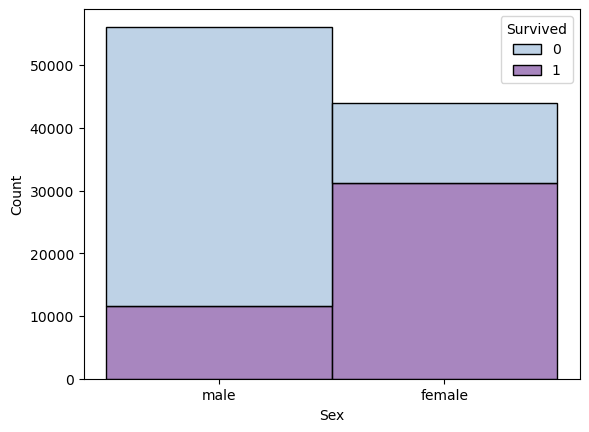

In [143]:
sns.histplot(data=data, stat="count", multiple="stack",
             x="Sex", kde=False,
             palette="BuPu", hue="Survived",
             element="bars", legend=True)

In [144]:
df = data.loc[(data.Sex=='female')]
pd.DataFrame({
    'count': df['Survived'].value_counts(),
    '%': df['Survived'].value_counts() / df.shape[0]
})

,count,%
1,31226,0.711525
0,12660,0.288475


In [145]:
dm = data.loc[(data.Sex=='male')]
pd.DataFrame({
    'count': dm['Survived'].value_counts(),
    '%': dm['Survived'].value_counts() / dm.shape[0]
})

,count,%
0,44566,0.794205
1,11548,0.205795


< your thoughts >

Sex has a significant impact on survival with women having the survival rate of 71% while men have the survival rate of 20%. The crew was ordered to evacuate _women_ and children first, we can see through the data that this order was followed

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Text(0.5, 1.0, 'Age distribution')

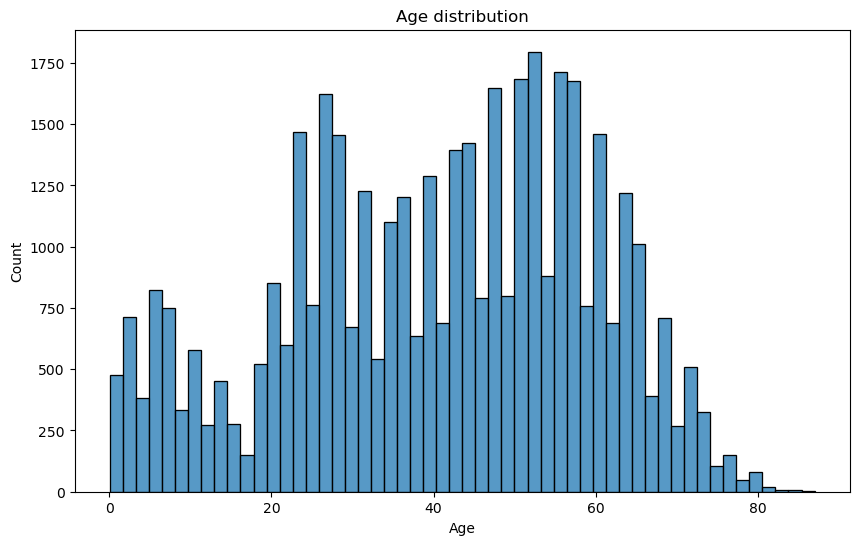

In [146]:
plt.figure(figsize=(10,6))
sns.histplot(data=data.loc[(data.Survived==1)], x='Age')
plt.title("Age distribution")

Average and median age of survived passengers

In [147]:
s = data.loc[(data.Survived==1)]
sm = s['Age'].mean()
smd = s['Age'].median()
sm, smd

(40.55379931430776, 43.0)

Average and median age of deceased passengers

In [148]:
s = data.loc[(data.Survived==0)]
sm = s['Age'].mean()
smd = s['Age'].median()
sm, smd

(36.708694881533724, 36.0)

Text(0.5, 1.0, 'Age distribution of deceased passengers')

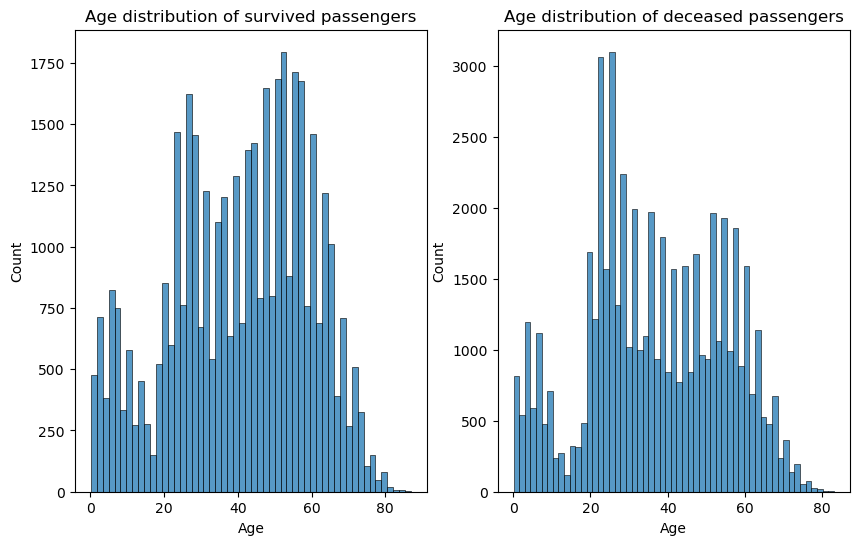

In [149]:
_, axes = plt.subplots(1, 2, figsize=(10,6))
sns.histplot(data=data.loc[(data.Survived==1)], x='Age', ax=axes[0]).set_title('Age distribution of survived passengers')
sns.histplot(data=data.loc[(data.Survived==0)], x='Age', ax=axes[1]).set_title('Age distribution of deceased passengers')

< your thoughts >

Overall deceased passengers were younger.
Main difference in age distribution begins with 'over 40' age group. 
Older people were more likely to be able to afford 1st and 2nd class tickets and class affected survival.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Pclass', ylabel='Count'>

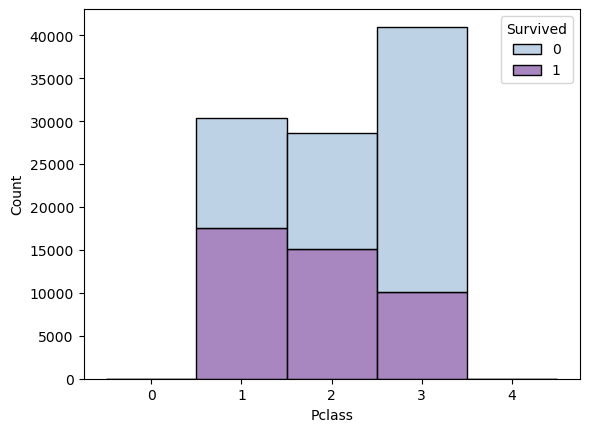

In [150]:
sns.histplot(data=data, stat="count", multiple="stack",
             x="Pclass", kde=False,
             palette="BuPu", hue="Survived",
             element="bars", legend=True, bins=np.arange(6)-0.5)

<AxesSubplot:xlabel='Embarked', ylabel='Count'>

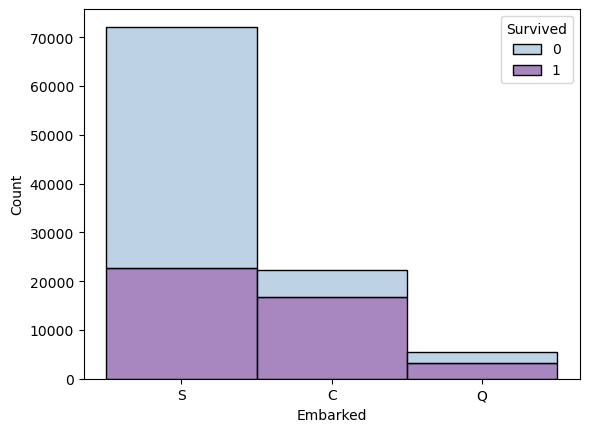

In [151]:
sns.histplot(data=data[data['Embarked'].notnull()], stat="count", multiple="stack",
             x="Embarked", kde=False,
             palette="BuPu", hue="Survived",
             element="bars", legend=True, bins=np.arange(6)-0.5)

<AxesSubplot:xlabel='Embarked', ylabel='Count'>

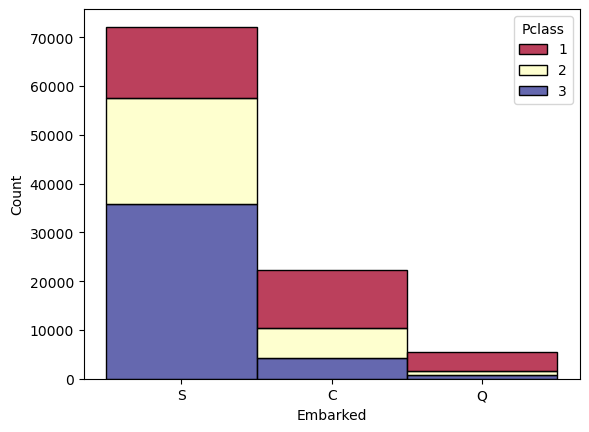

In [152]:
sns.histplot(data=data[data['Embarked'].notnull()], stat="count", multiple="stack",
             x="Embarked", kde=False,
             palette="RdYlBu", hue="Pclass",
             element="bars", legend=True, bins=np.arange(6)-0.5)

< your thoughts >

First class passengers have higher sirvival rate so it was "the safest". Passengers who embarked at port Q have higher survival rate but it is likely due to port Q having mostly 1st class passengers.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [153]:
pd.DataFrame({
    'Missing %': (data.isna().sum() / data.shape[0])*100
}).sort_values(by='Missing %', ascending=False)

,Missing %
Cabin,67.866
Ticket,4.623
Age,3.292
Embarked,0.250
Fare,0.134
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000
SibSp,0.000


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

Fare - fill null values with mean according to passengers's Class
Embarked - fill null values with port 'S' since most passengers embarked there
Age - fill null values with mean according to passengers's Sex and Class
Ticket - would drop this column
Cabin - could be inetersting to chech the theory that if we know someone's cabin, it's because the passenger survived and to explore the dependancy of survival rate and class on cabin level (first letter). But overall - would drop this column, missing percentage is too high.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Filling in NA values

In [154]:
data['Embarked'] = data['Embarked'].fillna('S')

In [155]:
data['Age'] = data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda group: group.fillna(group.mean()))

In [156]:
data['Fare'] = data.groupby(['Pclass'])['Fare'].transform(lambda group: group.fillna(group.mean()))

In [157]:
data = data.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [158]:
pd.DataFrame({
    'Missing %': (data.isna().sum() / data.shape[0])*100
}).sort_values(by='Missing %', ascending=False)

,Missing %
Survived,0.0
Pclass,0.0
Sex,0.0
Age,0.0
SibSp,0.0
Parch,0.0
Fare,0.0
Embarked,0.0


In [159]:
train = data

In [160]:
pd.DataFrame({
    'Missing %': (test.isna().sum() / test.shape[0])*100
}).sort_values(by='Missing %', ascending=False)

,Missing %
Cabin,70.831
Ticket,5.181
Age,3.487
Embarked,0.277
Fare,0.133
PassengerId,0.000
Pclass,0.000
Name,0.000
Sex,0.000
SibSp,0.000


In [161]:
test['Embarked'] = test['Embarked'].fillna('S')
test['Age'] = test.groupby(['Pclass', 'Sex'])['Age'].transform(lambda group: group.fillna(group.mean()))
test['Fare'] = test.groupby(['Pclass'])['Fare'].transform(lambda group: group.fillna(group.mean()))
test = test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [162]:
pd.DataFrame({
    'Missing %': (test.isna().sum() / test.shape[0])*100
}).sort_values(by='Missing %', ascending=False)

,Missing %
PassengerId,0.0
Pclass,0.0
Sex,0.0
Age,0.0
SibSp,0.0
Parch,0.0
Fare,0.0
Embarked,0.0


replace string values

In [163]:
train['Sex'] = np.where(train['Sex'] == 'male', 0, 1)

In [164]:
test['Sex'] = np.where(test['Sex'] == 'male', 0, 1)

In [165]:
train.loc[(train.Embarked == 'Q'),'Embarked']=1
train.loc[(train.Embarked == 'C'),'Embarked']=2
train.loc[(train.Embarked == 'S'),'Embarked']=3

In [166]:
test.loc[(test.Embarked == 'Q'),'Embarked']=1
test.loc[(test.Embarked == 'C'),'Embarked']=2
test.loc[(test.Embarked == 'S'),'Embarked']=3

 Logistic Regression

In [167]:
train.shape, test.shape

((100000, 8), (100000, 8))

In [168]:
train['Survived']

PassengerId
0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: Survived, Length: 100000, dtype: int64

In [169]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train[['Pclass', 'Sex', 'Age', 'Embarked', 'SibSp', 'Parch', 'Fare']], train['Survived'], test_size=0.25, random_state=0)

In [170]:
from sklearn.linear_model import LogisticRegression

In [171]:
logisticRegr = LogisticRegression(max_iter=1000)

In [172]:
logisticRegr.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [173]:
score = logisticRegr.score(x_train, y_train)
print(score)

0.75916


In [175]:
predictions = logisticRegr.predict(test[['Pclass', 'Sex', 'Age', 'Embarked', 'SibSp', 'Parch', 'Fare']])

In [181]:
sample_submission  = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

In [176]:
predictions

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [182]:
submission = pd.concat([sample_submission,pd.DataFrame(predictions)], axis=1).drop(columns=['Survived'])

In [ ]:
submission.columns = ['PassengerId', 'Survived']

In [189]:
submission.to_csv('out.csv', index=False)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

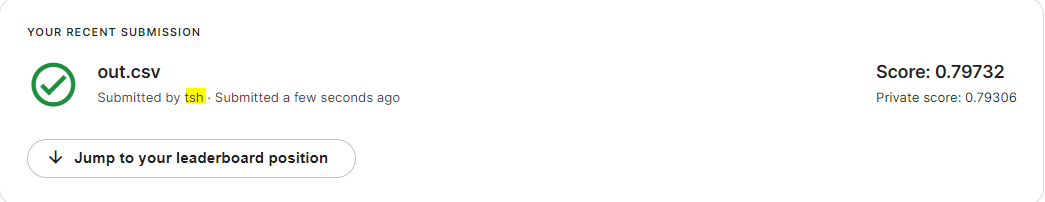